In [1]:
import tensorflow as tf
import os
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.mixed_precision import set_global_policy

In [2]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = (32, 32)
INPUT_SHAPE = (32, 32, 3)
EPOCHS = 100
BASE_LEARNING_RATE = 1e-3

In [3]:
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)  # Resize to match input size of the model
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

def create_dataset(image_paths, labels, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
    return dataset

def extract_paths_and_labels(directory_path, label):
    image_paths = []
    labels = []
    for subdir, _, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(subdir, file))
                labels.append(label)
    return image_paths, labels


In [4]:
real_dir = './data/processed/real/'
fake_dir = './data/processed/fake/'

# Extract paths and labels
real_paths, real_labels = extract_paths_and_labels(real_dir, label=0)
fake_paths, fake_labels = extract_paths_and_labels(fake_dir, label=1)

# Combine paths and labels
all_paths = np.array(real_paths + fake_paths)
all_labels = np.array(real_labels + fake_labels)


In [5]:
len(all_paths)

80353

In [6]:
len(all_labels)

80353

In [5]:
# Paths to directories

# # Apply undersampling to balance classes
# rus = RandomOverSampler(random_state=42)
# all_paths_resampled, all_labels_resampled = rus.fit_resample(all_paths.reshape(-1, 1), all_labels)
# all_paths_resampled = all_paths_resampled.flatten()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_paths, 
    all_labels, 
    test_size=0.4, 
    random_state=42, 
    stratify=all_labels
)

rus = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train.reshape(-1, 1), y_train)
X_train_resampled = X_train_resampled.flatten()


# Create TensorFlow datasets
train_dataset = create_dataset(X_train_resampled, y_train_resampled, shuffle=True)
test_dataset = create_dataset(X_test, y_test, shuffle=False)

In [8]:
from collections import Counter

# Check the distribution of training labels
train_label_counts = Counter(y_train_resampled)
print("Training label distribution:", train_label_counts)

# Check the distribution of test labels
test_label_counts = Counter(y_test)
print("Test label distribution:", test_label_counts)


Training label distribution: Counter({1: 43636, 0: 43636})
Test label distribution: Counter({1: 29092, 0: 3050})


In [8]:
# Define the improved model

def build_deepfake_model(input_shape=INPUT_SHAPE):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)

    # Add fully connected layers with dropout and batch normalization
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_deepfake_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [10]:

# Enable mixed precision training
set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
    
    
# Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='Models/Eb0_OVS_best_model_weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Cosine decay learning rate scheduler
cosine_decay = CosineDecay(initial_learning_rate=BASE_LEARNING_RATE, decay_steps=EPOCHS, alpha=0.1)

# Training
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback],
    class_weight={0: 1.0, 1: 1.0}  # Balance weights if needed
)

# Save the entire model
model.save('Models/Eb0_OVS_best_model.h5')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5
GPU setup error: Physical devices cannot be modified after being initialized
Epoch 1/100
2728/2728 [==============================] - ETA: 0s - loss: 1.2197 - accuracy: 0.6560
Epoch 1: val_loss improved from inf to 0.74321, saving model to Models\Eb0_OVS_best_model_weights.h5
2728/2728 [==============================] - 359s 114ms/step - loss: 1.2197 - accuracy: 0.6560 - val_loss: 0.7432 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 2/100
2728/2728 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.7742
Epoch 2: val_loss did not improve from 0.74321
2728/2728 [==============================] - 297s 109ms/step - loss: 0.5036 - accuracy: 0.7742 - val_loss: 1.0461 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 3/100
2728/2728 [=============

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [11]:
# Get predictions
y_pred_probs = model.predict(test_dataset, verbose=1)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

1005/1005 [==============================] - 19s 17ms/step


In [12]:
# Flatten the true labels and predictions
y_test_flat = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_flat = y_pred.flatten()

# Calculate metrics
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat))

print("Confusion Matrix:")
print(confusion_matrix(y_test_flat, y_pred_flat))


Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.71      0.32      3050
           1       0.96      0.71      0.82     29092

    accuracy                           0.71     32142
   macro avg       0.58      0.71      0.57     32142
weighted avg       0.89      0.71      0.77     32142

Confusion Matrix:
[[ 2156   894]
 [ 8361 20731]]


<Axes: >

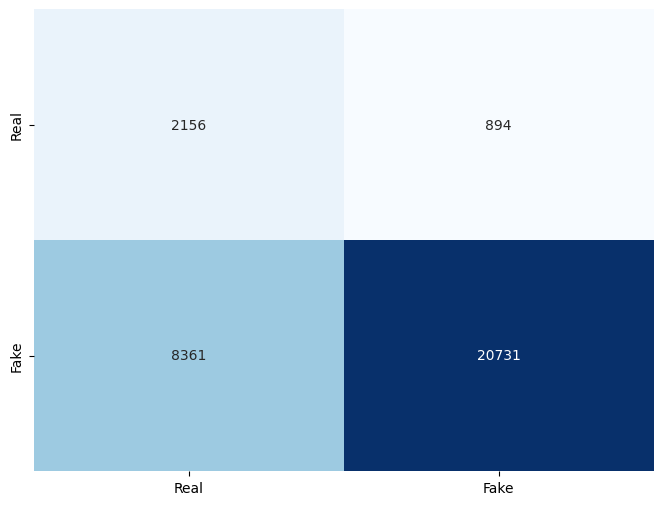

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test_flat, y_pred_flat)
plt.figure(figsize=(8, 6))  # You can adjust the size of the figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])

In [9]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Step 1: Extract frames from the video
def extract_frames_from_video(video_path, fps=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = max(1, int(video_fps / fps))

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1
    cap.release()
    return frames

# Step 2: Preprocess the frames
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = tf.convert_to_tensor(frame, dtype=tf.float32)
    frame = tf.image.resize(frame, [32, 32])
    frame = frame / 255.0
    return tf.expand_dims(frame, axis=0)

def preprocess_frames(frames):
    return np.vstack([preprocess_frame(frame) for frame in frames])


def predict_on_video(video_path):
    frames = extract_frames_from_video(video_path, fps=1)
    preprocessed_frames = preprocess_frames(frames)
    predictions = model_architecture.predict(preprocessed_frames)
    predicted_labels = (predictions > 0.5).astype(int)
    return predicted_labels

# Step 4: Aggregate the predictions
def aggregate_predictions(predicted_labels):
    real_count = np.sum(predicted_labels == 0)
    fake_count = np.sum(predicted_labels == 1)
    print(real_count ,"",fake_count)
    if fake_count > real_count:
        return 'Fake'
    else:
        return 'Real'

# Example: Predict for a video


In [10]:
# Step 3: Make predictions on the frames
model_architecture = build_deepfake_model()  # Replace with your model creation function
# Load the saved weights
model_architecture.load_weights('Models/Eb0_OVS_best_model_weights.h5')


In [11]:
video_path = './data/YouTube-real/00001.mp4'
predicted_labels = predict_on_video(video_path)
final_prediction = aggregate_predictions(predicted_labels)
print(f"The video is classified as: {final_prediction}")

1/1 [==============================] - 15s 15s/step
6  8
The video is classified as: Fake


In [23]:
def predict_on_videos_in_directory(directory_path):
    results = []
    
    for video_file in os.listdir(directory_path):
        video_path = os.path.join(directory_path, video_file)
        
        if video_file.endswith(('.mp4', '.avi', '.mov')):  # Check for video file formats
            print(f"Processing video: {video_file}")
            predicted_labels = predict_on_video(video_path)
            final_prediction = aggregate_predictions(predicted_labels)
            results.append((video_file, final_prediction))
            print(f"Prediction for {video_file}: {final_prediction}")
    
    return results

In [24]:
directory_path = './data/Celeb-synthesis/'  # Path to your directory containing videos
video_predictions = predict_on_videos_in_directory(directory_path)

# Display results for all videos
for video_file, prediction in video_predictions:
    print(f"Video: {video_file}, Prediction: {prediction}")


Processing video: id0_id16_0000.mp4
1/1 [==============================] - 0s 38ms/step
4  12
Prediction for id0_id16_0000.mp4: Fake
Processing video: id0_id16_0001.mp4
1/1 [==============================] - 0s 40ms/step
5  6
Prediction for id0_id16_0001.mp4: Fake
Processing video: id0_id16_0002.mp4
1/1 [==============================] - 0s 39ms/step
6  6
Prediction for id0_id16_0002.mp4: Real
Processing video: id0_id16_0003.mp4
1/1 [==============================] - 0s 39ms/step
7  11
Prediction for id0_id16_0003.mp4: Fake
Processing video: id0_id16_0004.mp4
1/1 [==============================] - 0s 38ms/step
2  9
Prediction for id0_id16_0004.mp4: Fake
Processing video: id0_id16_0005.mp4
1/1 [==============================] - 0s 48ms/step
6  10
Prediction for id0_id16_0005.mp4: Fake
Processing video: id0_id16_0006.mp4
1/1 [==============================] - 0s 36ms/step
7  11
Prediction for id0_id16_0006.mp4: Fake
Processing video: id0_id16_0007.mp4
1/1 [==============================]

KeyboardInterrupt: 

In [12]:
directory_path = './data/YouTube-real/'  # Path to your directory containing videos
video_predictions = predict_on_videos_in_directory(directory_path)

# Display results for all videos
for video_file, prediction in video_predictions:
    print(f"Video: {video_file}, Prediction: {prediction}")


NameError: name 'predict_on_videos_in_directory' is not defined

1005/1005 [==============================] - 17s 16ms/step
AUC: 0.78


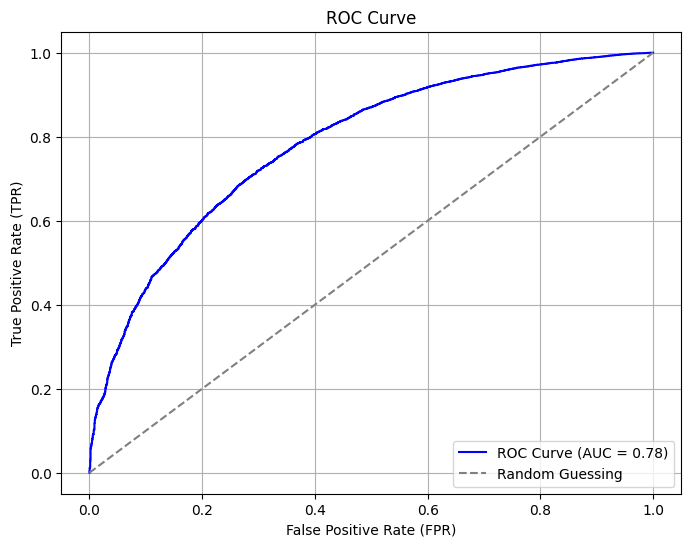

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Step 4: Get predicted probabilities using the `predict` method
y_pred_proba = model.predict(test_dataset)  # This returns probabilities for the positive class

# Step 5: Compute ROC curve (FPR, TPR, thresholds)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Step 6: Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

# Step 7: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [5]:
# Paths to directories

rus = RandomOverSampler(random_state=42)
all_paths_resampled, all_labels_resampled = rus.fit_resample(all_paths.reshape(-1, 1), all_labels)
all_paths_resampled = all_paths_resampled.flatten()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_paths_resampled, 
    all_labels_resampled, 
    test_size=0.3, 
    random_state=42, 
    stratify=all_labels_resampled
)


# Create TensorFlow datasets
train_dataset = create_dataset(X_train, y_train, shuffle=True)
test_dataset = create_dataset(X_test, y_test, shuffle=False)

In [6]:
from collections import Counter

# Check the distribution of training labels
train_label_counts = Counter(y_train)
print("Training label distribution:", train_label_counts)

# Check the distribution of test labels
test_label_counts = Counter(y_test)
print("Test label distribution:", test_label_counts)


Training label distribution: Counter({1: 50910, 0: 50909})
Test label distribution: Counter({0: 21819, 1: 21818})


In [7]:
# Define the improved model

def build_deepfake_model(input_shape=INPUT_SHAPE):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)

    # Add fully connected layers with dropout and batch normalization
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_deepfake_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [8]:

# Enable mixed precision training
set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
    
    
# Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='Models/Eb0_OVS2_best_model_weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Cosine decay learning rate scheduler
cosine_decay = CosineDecay(initial_learning_rate=BASE_LEARNING_RATE, decay_steps=EPOCHS, alpha=0.1)

# Training
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback],
    class_weight={0: 1.0, 1: 1.0}  # Balance weights if needed
)

# Save the entire model
model.save('Models/Eb0_OVS2_best_model.h5')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5
GPU setup error: Physical devices cannot be modified after being initialized
Epoch 1/100
3182/3182 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.6396
Epoch 1: val_loss improved from inf to 0.63959, saving model to Models\Eb0_OVS2_best_model_weights.h5
3182/3182 [==============================] - 402s 108ms/step - loss: 1.0871 - accuracy: 0.6396 - val_loss: 0.6396 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 2/100
3182/3182 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.6923
Epoch 2: val_loss did not improve from 0.63959
3182/3182 [==============================] - 355s 111ms/step - loss: 0.6192 - accuracy: 0.6923 - val_loss: 0.6701 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 3/100
3182/3182 [============

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [2]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)
INPUT_SHAPE = (64, 64, 3)
EPOCHS = 100
BASE_LEARNING_RATE = 1e-3

In [3]:
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)  # Resize to match input size of the model
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

def create_dataset(image_paths, labels, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
    return dataset

def extract_paths_and_labels(directory_path, label):
    image_paths = []
    labels = []
    for subdir, _, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(subdir, file))
                labels.append(label)
    return image_paths, labels


In [4]:
real_dir = './data/processed/real/'
fake_dir = './data/processed/fake/'

# Extract paths and labels
real_paths, real_labels = extract_paths_and_labels(real_dir, label=0)
fake_paths, fake_labels = extract_paths_and_labels(fake_dir, label=1)

# Combine paths and labels
all_paths = np.array(real_paths + fake_paths)
all_labels = np.array(real_labels + fake_labels)


In [5]:
# Paths to directories

rus = RandomOverSampler(random_state=42)
all_paths_resampled, all_labels_resampled = rus.fit_resample(all_paths.reshape(-1, 1), all_labels)
all_paths_resampled = all_paths_resampled.flatten()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_paths_resampled, 
    all_labels_resampled, 
    test_size=0.3, 
    random_state=42, 
    stratify=all_labels_resampled
)


# Create TensorFlow datasets
train_dataset = create_dataset(X_train, y_train, shuffle=True)
test_dataset = create_dataset(X_test, y_test, shuffle=False)

In [6]:
# Define the improved model

def build_deepfake_model(input_shape=INPUT_SHAPE):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)

    # Add fully connected layers with dropout and batch normalization
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_deepfake_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [7]:

# Enable mixed precision training
set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
    
    
# Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='Models/Eb0_OVS3_best_model_weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Cosine decay learning rate scheduler
cosine_decay = CosineDecay(initial_learning_rate=BASE_LEARNING_RATE, decay_steps=EPOCHS, alpha=0.1)

# Training
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback],
    class_weight={0: 1.0, 1: 1.0}  # Balance weights if needed
)

# Save the entire model
model.save('Models/Eb0_OVS3_best_model.h5')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5
GPU setup error: Physical devices cannot be modified after being initialized
Epoch 1/100
3182/3182 [==============================] - ETA: 0s - loss: 0.8177 - accuracy: 0.8255
Epoch 1: val_loss improved from inf to 0.24497, saving model to Models\Eb0_OVS3_best_model_weights.h5
3182/3182 [==============================] - 927s 184ms/step - loss: 0.8177 - accuracy: 0.8255 - val_loss: 0.2450 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 2/100
3182/3182 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9102
Epoch 2: val_loss did not improve from 0.24497
3182/3182 [==============================] - 433s 136ms/step - loss: 0.2373 - accuracy: 0.9102 - val_loss: 0.3175 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 3/100
3182/3182 [============

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.